### Library and package definitions

In [1]:
# for data analysis
import pandas as pd
import numpy as np


#For data Modeling
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier



#For NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#Miscellaneous

# for progress  bars
from tqdm import tqdm

#regular expressions
import re

#for .pkl file
import joblib


#for hyperparameter tuning
from hyperopt import fmin, tpe, hp

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp

## Reading the data 

In [2]:
df = pd.read_csv("mbti.csv") 
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Handling class imbalance issues
This will help in ensuring each class has a balanced representation during training and evaluation

In [3]:
# Calculate the target sample size per class
total_samples = df.shape[0]
num_classes = len(df['type'].unique())
target_samples_per_class = total_samples // num_classes

In [4]:
# The code below prepares a dictionary to store posts for each unique personality type and sets up lists for balanced features and labels
# Dictionary to store posts for each personality type
personality_posts = {ptype: [] for ptype in df['type'].unique()}

# Iterate through each row and populate the dictionary
for index, row in df.iterrows():
    personality_posts[row['type']].append(row['posts'])

# Lists to store balanced data
balanced_features = []
balanced_labels = []

#### Balancing the dataset by randomly sampling the posts for every MBTI type

It is done to ensure consistency across the number of samples across every MBTI type.

In [5]:
# Iterate through each personality type
for personality_type, posts in personality_posts.items():
    num_samples = len(posts)
    
    if num_samples >= target_samples_per_class:
        # Sample random indices
        sampled_indices = np.random.choice(num_samples, target_samples_per_class, replace=False)
        
        # Add the sampled data to the balanced sets
        balanced_features.extend([posts[i] for i in sampled_indices])
        balanced_labels.extend([personality_type] * target_samples_per_class)
    else:
        # If fewer posts than target_samples_per_class, use all available posts
        balanced_features.extend(posts)
        balanced_labels.extend([personality_type] * num_samples)

#### Shuffling is performed to randomize the order of data instances

This will ensure that any order-related bias is reduced

In [6]:
# Shuffle the data
shuffled_indices = np.random.permutation(len(balanced_features))
balanced_features = [balanced_features[i] for i in shuffled_indices]
balanced_labels = [balanced_labels[i] for i in shuffled_indices]

# Split into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    balanced_features, balanced_labels, test_size=0.2, random_state=42
)

### Cleaning the text

The following method peforms these functions :

 - Lowercasing to ensure uniformity in case.

 - URL Removal using regular expressions.

 - Non-Alphanumeric Character Removal, keeping only letters and numbers.

 - Lemmatization to reduce inflected words to their base or root form.
 
 the output retruned is :
 - cleaned_text: cleaned and preprocessed sentences.
 - data_length: the number of words in each cleaned sentence.

In [7]:
def clean_text(data):
    data_length = []
    lemmatizer = WordNetLemmatizer()
    cleaned_text = []
    for sentence in tqdm(data):
        sentence = sentence.lower()

        # Removing URLs
        sentence = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+', ' ', sentence)

        # Removing non-alphanumeric characters
        sentence = re.sub('[^0-9a-z]', ' ', sentence)

        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text, data_length



In [8]:
# Clean train and test features
cleaned_train_features, train_data_lengths = clean_text(train_features)


100%|█████████████████████████████████████| 3896/3896 [00:02<00:00, 1723.17it/s]


In [9]:
cleaned_test_features, test_data_lengths = clean_text(test_features)

100%|███████████████████████████████████████| 974/974 [00:00<00:00, 1724.81it/s]


##### Lemmatisation
The code defines a custom lemmatiser class, that utilises the wordnet lemmatiser. It can be called from anywhere within the code and it will lemmatise the entire input sentence and return base form of the words.

In [10]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word) > 2]

# Initialize the Lemmatizer
lemmatizer = Lemmatizer()

### Vectorisation
- In the following cells, the cleaned train and test features are lemmatised by calling the lemmatiser above.
- The lemmatised features are converted back into sentences
- A TF-IDF vector is created from the lemmatised sentences, which is used by the model.

In [11]:
# Lemmatize cleaned train and test features
lemmatized_train_features = [lemmatizer(sentence) for sentence in cleaned_train_features]
lemmatized_test_features = [lemmatizer(sentence) for sentence in cleaned_test_features]

# Convert lemmatized features back to sentences
lemmatized_train_sentences = [' '.join(sentence) for sentence in lemmatized_train_features]
lemmatized_test_sentences = [' '.join(sentence) for sentence in lemmatized_test_features]

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

In [12]:
# Fit the vectorizer on lemmatized training data and transform training and testing data
train_post = vectorizer.fit_transform(lemmatized_train_sentences)
test_post = vectorizer.transform(lemmatized_test_sentences)
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

### Visualizing the feature names extracted from the TfidfVectorizer

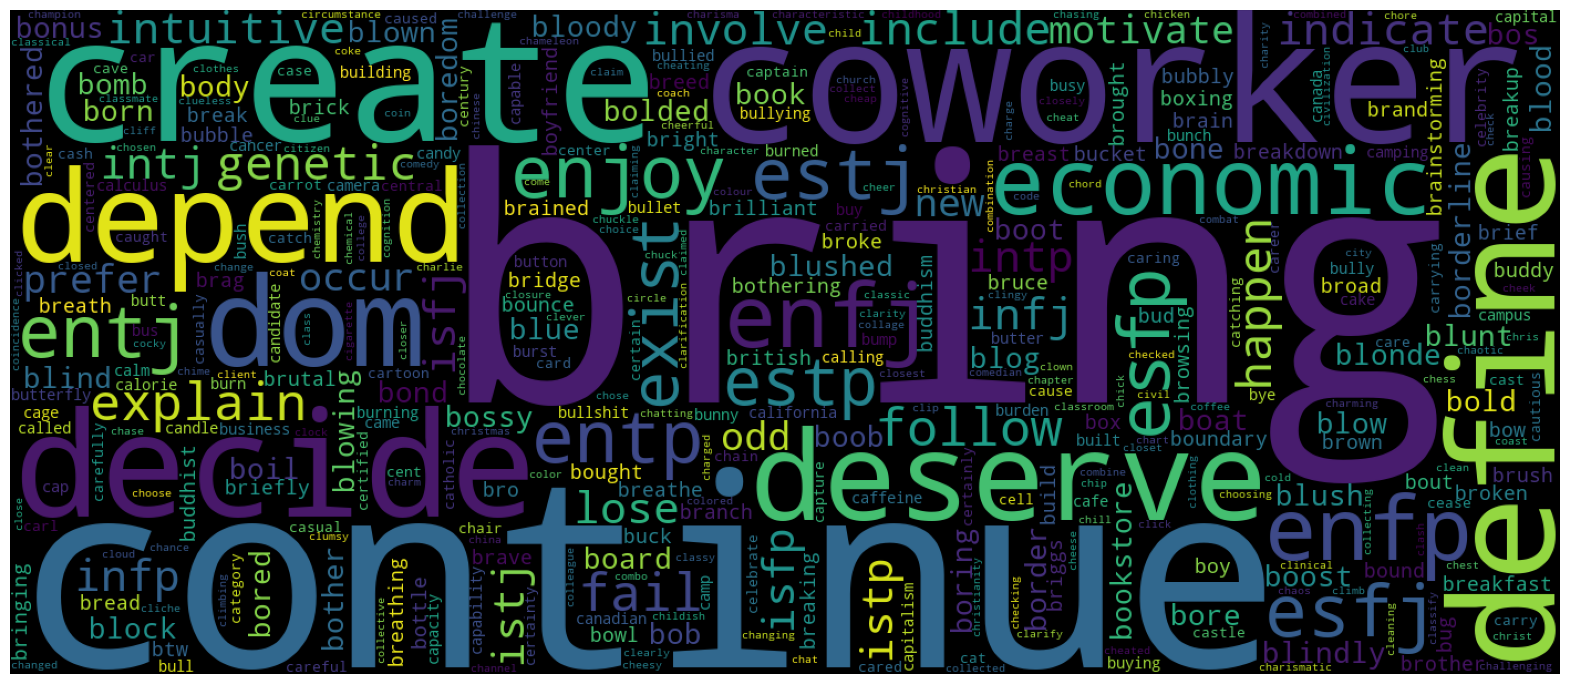

In [13]:
feature_names=vectorizer.get_feature_names_out()
wc=WordCloud(max_words=400, width=1400, height=600, collocations=False, background_color="black", colormap="viridis")

# generates the word cloud from the feature names. 
# It first selects a subset of feature names by slicing the feature_names array from index 500 to 3500. 
# It then joins these feature names into a single string separated by spaces
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [14]:
# Labels are present as string so they need to be encoded as numerals in order to  be passed to the model
label_encoder = LabelEncoder()

# Fit and transform labels for both training and testing sets
train_target = label_encoder.fit_transform(train_labels)
test_target = label_encoder.transform(test_labels)
# Save the label encoder for later use
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [15]:
# Get the mapping between encoded labels and original labels
encoded_to_original_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
encoded_to_original_mapping

{'ENFJ': 0,
 'ENFP': 1,
 'ENTJ': 2,
 'ENTP': 3,
 'ESFJ': 4,
 'ESFP': 5,
 'ESTJ': 6,
 'ESTP': 7,
 'INFJ': 8,
 'INFP': 9,
 'INTJ': 10,
 'INTP': 11,
 'ISFJ': 12,
 'ISFP': 13,
 'ISTJ': 14,
 'ISTP': 15}

In [16]:
# Initialising array for storing accuracy scores from different models 
models_accuracy={}

### Logistic Regression

Why Logistic Regression?

>Logistic Regression is a linear model that works well with text data represented as TF-IDF features. 
>It can handle high-dimensional feature spaces efficiently, which is common in NLP tasks with large vocabularies

> Logistic Regression provides interpretable results, as the coefficients associated with each feature indicate the impact of that feature on the probability of the positive class.

> Regularization paramter is used to prevent over fitting

In [17]:
#defining the model and it's parameters
model_log = LogisticRegression(max_iter=1000,C=0.875994176464719,n_jobs=-1,
                               solver='saga', multi_class='multinomial', penalty='l2')
#fitting the model
model_log.fit(train_post,train_target)

LogisticRegression(C=0.875994176464719, max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, solver='saga')

In [18]:

# Generate classification reports for the test and train data

print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),zero_division=1,target_names=label_encoder.inverse_transform([i for i in range(16)])))
print('Test classification report:\n', classification_report(test_target, model_log.predict(test_post),zero_division=1, target_names=label_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.92      0.59      0.72       160
        ENFP       0.81      0.85      0.83       440
        ENTJ       0.91      0.68      0.78       191
        ENTP       0.80      0.87      0.84       424
        ESFJ       0.86      0.16      0.27        38
        ESFP       1.00      0.00      0.00        36
        ESTJ       1.00      0.03      0.06        33
        ESTP       0.95      0.29      0.44        63
        INFJ       0.80      0.86      0.83       431
        INFP       0.74      0.91      0.82       436
        INTJ       0.75      0.90      0.82       429
        INTP       0.74      0.92      0.82       428
        ISFJ       0.91      0.64      0.75       133
        ISFP       0.89      0.68      0.77       220
        ISTJ       0.88      0.66      0.76       169
        ISTP       0.87      0.88      0.87       265

    accuracy                           0.80      

In [19]:
#dumping the trained model into a pkl file
joblib.dump(model_log, "logistic_reg_model.pkl")

['logistic_reg_model.pkl']

In [20]:
#store accuracy score in theh array defiend earlier
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

#display accuracy score
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,logistic regression,0.61499


### Hyperparamter Optimisation
Why?
Bayesian optimization can handle noisy observations by modeling the noise and making informed decisions about where to sample next.

Bayesian optimization can be parallelized, allowing multiple evaluations of the objective function to occur simultaneously

Fewer Function Evaluations: Compared to traditional grid search or random search methods, Bayesian optimization often requires significantly fewer function evaluations

In [21]:
# Define mappings for solver and penalty
solver_mapping = {0: 'lbfgs', 1: 'liblinear', 2: 'saga'}
penalty_mapping = {0: 'l2'}

def logistic_regression_hyperparameter_tuning(params):
    solver = solver_mapping[params['solver']]
    penalty = penalty_mapping[params['penalty']] if solver != 'lbfgs' else 'l2'

    model = LogisticRegression(
        max_iter=int(params['max_iter']),
        C=params['C'],
        solver=solver,
        penalty=penalty
    )

    cv_scores = cross_val_score(model, train_post, train_target, cv=5)
    avg_cv_accuracy = np.mean(cv_scores)

    return -avg_cv_accuracy  # Minimize negative accuracy

logistic_space = {
    'max_iter': hp.quniform('max_iter', 1000, 5000, 1000),
    'C': hp.uniform('C', 0.1, 1.0),
    'solver': hp.choice('solver', [0, 1, 2]),  # Use indices
    'penalty': hp.choice('penalty', [0])  # Use index
}

best_logistic = fmin(fn=logistic_regression_hyperparameter_tuning, space=logistic_space, algo=tpe.suggest, max_evals=10)

# Convert indices to names for solver and penalty
best_logistic['solver'] = solver_mapping[best_logistic['solver']]
best_logistic['penalty'] = penalty_mapping[best_logistic['penalty']]

print("Best Logistic Regression Hyperparameters:", best_logistic)


100%|████████| 10/10 [01:44<00:00, 10.40s/trial, best loss: -0.6278272604588394]
Best Logistic Regression Hyperparameters: {'C': 0.9692073861853877, 'max_iter': 3000.0, 'penalty': 'l2', 'solver': 'saga'}


In [22]:
# Re-run the logit model using best hyperparameters & observe the results

In [23]:
model_log=LogisticRegression(max_iter=4000,C=0.8695694949901974,n_jobs=-1, solver='saga', multi_class='multinomial', penalty='l1', random_state=6)
model_log.fit(train_post,train_target)
joblib.dump(model_log, "logistic_reg_model.pkl")

['logistic_reg_model.pkl']

In [24]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

In [25]:
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,logistic regression,0.64271


## MLP

Iteration 1, loss = 2.57166302
Iteration 2, loss = 2.53933847
Iteration 3, loss = 2.53655913
Iteration 4, loss = 2.53215701
Iteration 5, loss = 2.52385974
Iteration 6, loss = 2.51846285
Iteration 7, loss = 2.50036478
Iteration 8, loss = 2.47938559
Iteration 9, loss = 2.44753717
Iteration 10, loss = 2.39943599
Iteration 11, loss = 2.33171526
Iteration 12, loss = 2.23977108
Iteration 13, loss = 2.13272434
Iteration 14, loss = 2.02545712
Iteration 15, loss = 1.91363688
Iteration 16, loss = 1.79538446
Iteration 17, loss = 1.67802370
Iteration 18, loss = 1.54786641
Iteration 19, loss = 1.42564275
Iteration 20, loss = 1.29617777
Iteration 21, loss = 1.17818755
Iteration 22, loss = 1.06413335
Iteration 23, loss = 0.96122679
Iteration 24, loss = 0.87444645
Iteration 25, loss = 0.79045587
Iteration 26, loss = 0.71071359
Iteration 27, loss = 0.64776872
Iteration 28, loss = 0.58943853
Iteration 29, loss = 0.53382065
Iteration 30, loss = 0.48871843
Iteration 31, loss = 0.44584429
Iteration 32, los

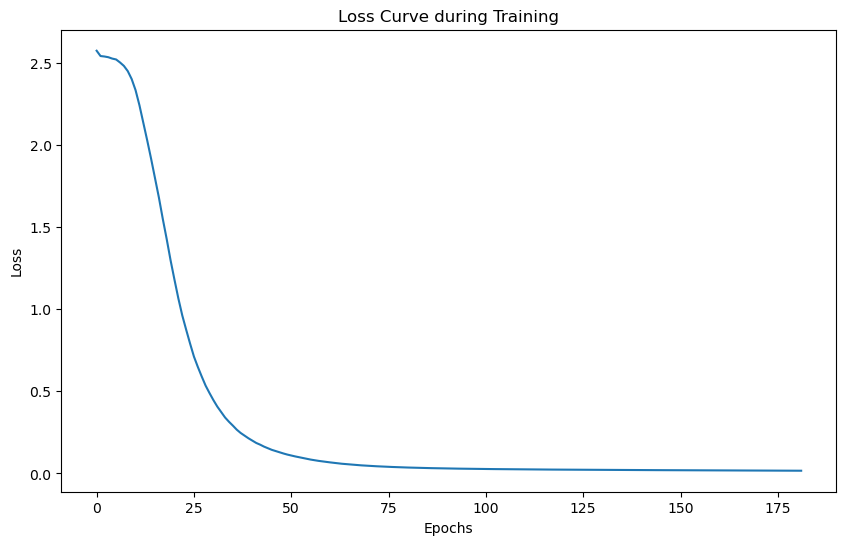

In [26]:
# Create an MLP classifier
model_mlp = MLPClassifier(hidden_layer_sizes=(300, 200), max_iter=1000, alpha=1e-4, activation ='logistic',
                         solver='adam', verbose=10, random_state=6, learning_rate_init=0.001)

# Fit the MLP classifier on the training data
model_mlp.fit(train_post, train_target)

# Trigger the creation of the loss curve
loss_curve = model_mlp.loss_curve_

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_curve)
plt.title('Loss Curve during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [27]:
# Generate classification reports for the test data
print('Test classification report:\n', classification_report(test_target, model_mlp.predict(test_post),zero_division=1, target_names=label_encoder.inverse_transform([i for i in range(16)])))

Test classification report:
               precision    recall  f1-score   support

        ENFJ       0.35      0.37      0.36        30
        ENFP       0.54      0.53      0.53       102
        ENTJ       0.47      0.45      0.46        40
        ENTP       0.59      0.62      0.60       118
        ESFJ       0.20      0.25      0.22         4
        ESFP       0.08      0.08      0.08        12
        ESTJ       0.00      0.00      1.00         6
        ESTP       0.44      0.27      0.33        26
        INFJ       0.45      0.50      0.48       111
        INFP       0.47      0.50      0.49       106
        INTJ       0.44      0.54      0.48       113
        INTP       0.48      0.47      0.48       114
        ISFJ       0.61      0.42      0.50        33
        ISFP       0.50      0.39      0.44        51
        ISTJ       0.34      0.33      0.34        36
        ISTP       0.66      0.54      0.60        72

    accuracy                           0.49       9

In [28]:
# Assuming you already have the MLP model named model_mlp
mlp_accuracy = accuracy_score(test_target, model_mlp.predict(test_post))

# Store the accuracy score in the models_accuracy dictionary
models_accuracy['MLP'] = mlp_accuracy

# Save the trained MLP model to a file using joblib
joblib.dump(model_mlp, "mlp_model.pkl")

['mlp_model.pkl']

In [29]:
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,logistic regression,0.642710
1,MLP,0.486653


### Naive Bayes Multinomial

Why Naive Bayes?

Uses probabilistic approach. This probabilistic approach is well-aligned with the nature of text data, where the frequency of words plays a critical role in determining the class.

NLP tasks often involve working with text data, and one common representation is the bag-of-words model or its extension, the term frequency-inverse document frequency (TF-IDF) representation. Multinomial Naive Bayes can handle these representations efficiently by modeling the probabilities of word occurrences.

Handles Multiclass Classification: Multinomial Naive Bayes can handle multiclass classification problems where there are more than two classes to predict

In [30]:
# Specifying model params

model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [31]:
# Generating classification report
print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),zero_division=1,target_names=label_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),zero_division=1,target_names=label_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.00      0.00       160
        ENFP       0.36      0.94      0.53       440
        ENTJ       1.00      0.00      0.00       191
        ENTP       0.61      0.81      0.70       424
        ESFJ       1.00      0.00      0.00        38
        ESFP       1.00      0.00      0.00        36
        ESTJ       1.00      0.00      0.00        33
        ESTP       1.00      0.00      0.00        63
        INFJ       0.74      0.84      0.79       431
        INFP       0.58      0.88      0.70       436
        INTJ       0.71      0.79      0.75       429
        INTP       0.69      0.84      0.76       428
        ISFJ       1.00      0.00      0.00       133
        ISFP       1.00      0.00      0.01       220
        ISTJ       0.67      0.01      0.02       169
        ISTP       1.00      0.18      0.30       265

    accuracy                           0.58      

In [32]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

In [33]:
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,logistic regression,0.642710
1,MLP,0.486653
2,Multinomial Naive Bayes,0.373717


### XGBoost

Why XGBoost?

>XGBoost can handle text data effectively by converting it into numerical representations through techniques like TF-IDF or word embeddings

> XGBoost uses an ensemble of decision trees to make predictions, so intricate patterns can be captured

>As data is high dimensional, regularization is required, it supports L1 and L2 regularization

> efficient and scalable

> Can handle imbalance in class


In [34]:
# Specifying model params
model_xgb=XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1)
model_xgb.fit(train_post,train_target)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [35]:
# Classification report
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=label_encoder.inverse_transform([i for i in range(16)])))
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

test classification report 
                precision    recall  f1-score   support

        ENFJ       0.47      0.50      0.48        30
        ENFP       0.61      0.73      0.66       102
        ENTJ       0.60      0.53      0.56        40
        ENTP       0.61      0.70      0.65       118
        ESFJ       0.50      0.25      0.33         4
        ESFP       1.00      0.17      0.29        12
        ESTJ       0.40      0.33      0.36         6
        ESTP       0.44      0.15      0.23        26
        INFJ       0.56      0.60      0.58       111
        INFP       0.61      0.66      0.64       106
        INTJ       0.61      0.58      0.59       113
        INTP       0.68      0.66      0.67       114
        ISFJ       0.63      0.52      0.57        33
        ISFP       0.60      0.67      0.63        51
        ISTJ       0.74      0.47      0.58        36
        ISTP       0.68      0.68      0.68        72

    accuracy                           0.61       

In [36]:
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,logistic regression,0.642710
1,MLP,0.486653
2,Multinomial Naive Bayes,0.373717
3,XGBoost Classifier,0.612936


In [37]:
joblib.dump(model_xgb, "xgb_model.pkl")

['xgb_model.pkl']

### Random forest
>Since it uses an aggregation of decision trees and combines their prediction ability, it produces more
accurate results. This is possible due to each of the individual trees are trained on a different subset of
data and features.

• The above in turn helps in reducing over fitting.

• Random forest assigns feature imporatance scores, and thus it helps in identifying most relevant words
that contribute towards the prediction.

In [38]:
# Specifying model params for Random Forest
model_rf = RandomForestClassifier(max_depth=30, n_estimators=3000, n_jobs=-1)

# Training the Random Forest model
model_rf.fit(train_post, train_target)

RandomForestClassifier(max_depth=30, n_estimators=3000, n_jobs=-1)

In [39]:
# Classification report for Random Forest
print('Test classification report for Random Forest:\n', classification_report(test_target, model_rf.predict(test_post),zero_division=1, target_names=label_encoder.inverse_transform([i for i in range(16)])))

# Accuracy for Random Forest
models_accuracy['Random Forest Classifier'] = accuracy_score(test_target, model_rf.predict(test_post))

Test classification report for Random Forest:
               precision    recall  f1-score   support

        ENFJ       0.58      0.23      0.33        30
        ENFP       0.63      0.72      0.67       102
        ENTJ       0.75      0.38      0.50        40
        ENTP       0.57      0.73      0.64       118
        ESFJ       1.00      0.00      0.00         4
        ESFP       1.00      0.00      0.00        12
        ESTJ       1.00      0.00      0.00         6
        ESTP       0.50      0.04      0.07        26
        INFJ       0.59      0.61      0.60       111
        INFP       0.51      0.75      0.61       106
        INTJ       0.53      0.65      0.58       113
        INTP       0.64      0.79      0.71       114
        ISFJ       0.89      0.24      0.38        33
        ISFP       0.62      0.45      0.52        51
        ISTJ       0.79      0.42      0.55        36
        ISTP       0.82      0.68      0.74        72

    accuracy                     

In [40]:
accuracy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuracy

,Models,Test accuracy
0,logistic regression,0.642710
1,MLP,0.486653
2,Multinomial Naive Bayes,0.373717
3,XGBoost Classifier,0.612936
4,Random Forest Classifier,0.602669


In [41]:
joblib.dump(model_rf, "random_forest_model.pkl")

['random_forest_model.pkl']